In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
(dataset, info) = tfds.load("oxford_iiit_pet",
                            with_info=True,
                            as_supervised=True)

train_ds = dataset['train']
test_ds = dataset['test']

class_names = info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.LQ6QX1_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.LQ6QX1_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [3]:
dog_labels = tf.constant(
    [i for i, name in enumerate(class_names) if name[0].islower()], dtype=tf.int64
)

def is_dog(image, label):
    return tf.reduce_any(tf.equal(dog_labels, label))

train_ds = train_ds.filter(is_dog)
test_ds = test_ds.filter(is_dog)

dog_class_names = [class_names[i] for i in dog_labels.numpy()]
NUM_CLASSES = len(dog_class_names)

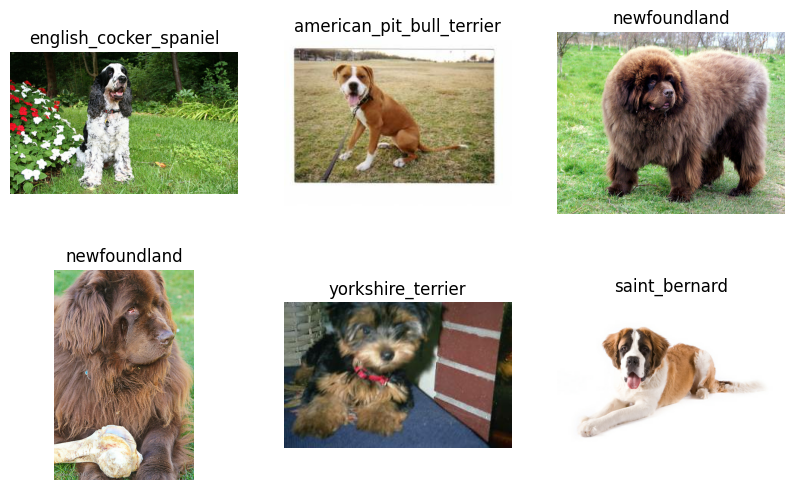

In [4]:
plt.figure(figsize=(10,6))

label_map = {original_idx: new_idx for new_idx, original_idx in enumerate(dog_labels.numpy())}

for i, (image, label) in enumerate(train_ds.take(6)):
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    plt.title(dog_class_names[label_map[label.numpy()]])
    plt.axis('off')
plt.show()

In [5]:
IMG_SIZE = 224

label_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(label_map.keys()), dtype=tf.int64),
        values=tf.constant(list(label_map.values()), dtype=tf.int64)
    ),
    default_value=-1
)

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    remapped_label = label_table.lookup(label)
    return image, remapped_label

train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [6]:
counter = Counter()

for _, label in train_ds.unbatch():
    counter[label.numpy().item()] += 1

print("Class Distribution:")
for i in range(NUM_CLASSES):
    print(dog_class_names[i], ":", counter[i])

Class Distribution:
american_bulldog : 100
american_pit_bull_terrier : 100
basset_hound : 100
beagle : 100
boxer : 100
chihuahua : 100
english_cocker_spaniel : 96
english_setter : 100
german_shorthaired : 100
great_pyrenees : 100
havanese : 100
japanese_chin : 100
keeshond : 100
leonberger : 100
miniature_pinscher : 100
newfoundland : 96
pomeranian : 100
pug : 100
saint_bernard : 100
samoyed : 100
scottish_terrier : 100
shiba_inu : 100
staffordshire_bull_terrier : 100
wheaten_terrier : 100
yorkshire_terrier : 100


In [7]:
def create_cnn_model(num_classes):
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Fourth Convolutional Block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Fifth Convolutional Block
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Global Average Pooling and Dense Layers
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [8]:
# Create and compile the model
model = create_cnn_model(NUM_CLASSES)

# Display model summary
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,123,641 (19.55 MB)

 Trainable params: 5,118,137 (19.52 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [9]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs= 40
)

Epoch 1/40
     78/Unknown 81s 519ms/step - accuracy: 0.0499 - loss: 4.4599

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


78/78 ━━━━━━━━━━━━━━━━━━━━ 99s 753ms/step - accuracy: 0.0499 - loss: 4.4583 - val_accuracy: 0.0406 - val_loss: 21.8280
Epoch 2/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 315ms/step - accuracy: 0.0488 - loss: 4.0785 - val_accuracy: 0.0390 - val_loss: 4.7127
Epoch 3/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 741ms/step - accuracy: 0.0591 - loss: 3.8069 - val_accuracy: 0.0442 - val_loss: 4.6056
Epoch 4/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.0566 - loss: 3.6476 - val_accuracy: 0.0531 - val_loss: 3.6000
Epoch 5/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 55s 654ms/step - accuracy: 0.0785 - loss: 3.5709 - val_accuracy: 0.0632 - val_loss: 3.2796
Epoch 6/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 311ms/step - accuracy: 0.0738 - loss: 3.4654 - val_accuracy: 0.0853 - val_loss: 3.1974
Epoch 7/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.0801 - loss: 3.3869 - val_accuracy: 0.0696 - val_loss: 3.2366
Epoch 8/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.1008 - loss: 3.2604 - val_accuracy: 0.09

In [10]:
model.save("dog_breed_model.keras")
print("Model saved successfully.")

Model saved successfully.


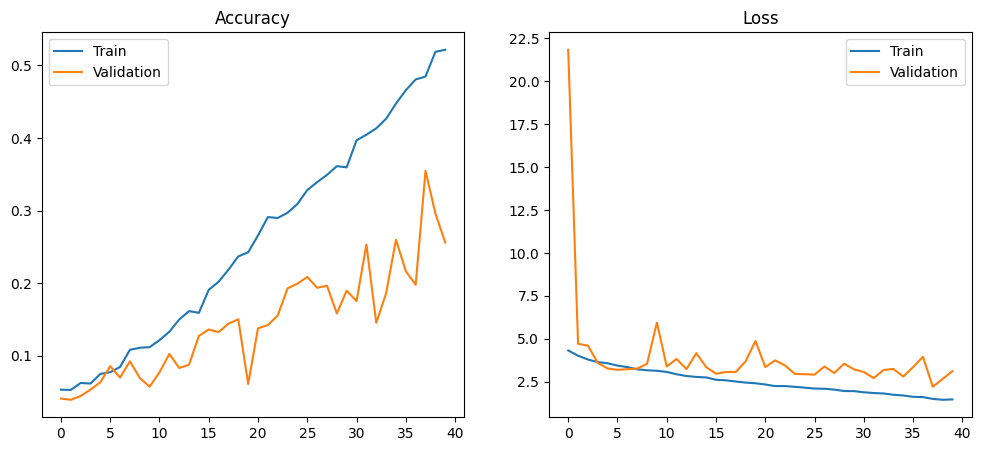

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.2631 - loss: 3.0674
Test Accuracy: 0.2558326721191406


In [13]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dog_class_names))


Classification Report:
                            precision    recall  f1-score   support

          american_bulldog       0.28      0.16      0.20       100
 american_pit_bull_terrier       0.50      0.02      0.04       100
              basset_hound       0.44      0.16      0.24       100
                    beagle       0.36      0.05      0.09       100
                     boxer       0.08      0.02      0.03        99
                 chihuahua       0.11      0.02      0.03       100
    english_cocker_spaniel       0.03      0.01      0.02       100
            english_setter       0.15      0.07      0.10       100
        german_shorthaired       0.39      0.22      0.28       100
            great_pyrenees       0.36      0.33      0.34       100
                  havanese       0.22      0.14      0.17       100
             japanese_chin       0.25      0.63      0.36       100
                  keeshond       0.21      0.74      0.33        99
                leonber

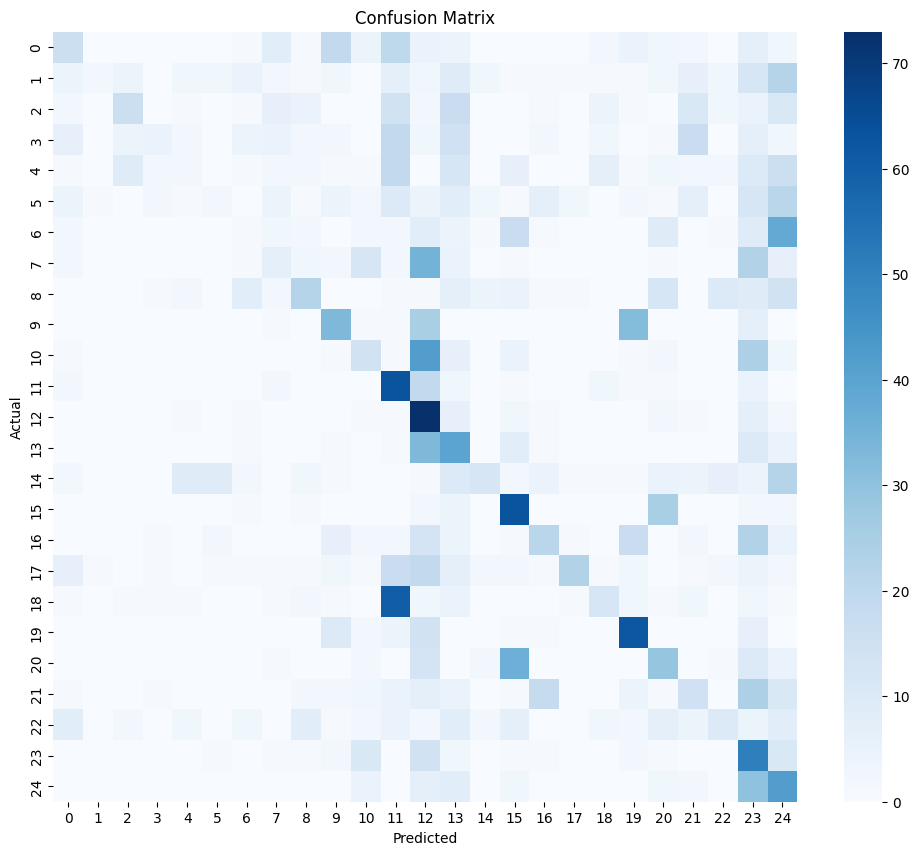

In [14]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

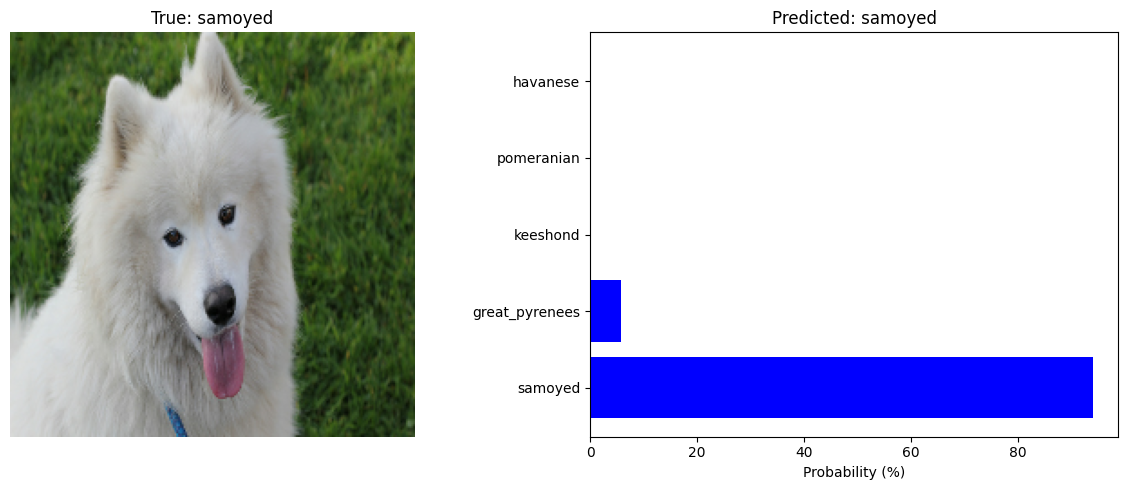

In [15]:
def predict_and_display(index):
    image, label = list(test_ds.unbatch())[index]
    input_img = tf.expand_dims(image, axis=0)

    probs = model.predict(input_img, verbose=0)[0]
    pred_class = np.argmax(probs)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(f"True: {dog_class_names[label.numpy()]}")
    plt.axis('off')

    plt.subplot(1,2,2)
    # Show top 5 predictions
    top_5_indices = np.argsort(probs)[-5:][::-1]
    top_5_probs = probs[top_5_indices] * 100
    top_5_names = [dog_class_names[i] for i in top_5_indices]

    colors = ['green' if i == pred_class else 'blue' for i in range(5)]
    plt.barh(range(5), top_5_probs, color=colors)
    plt.yticks(range(5), top_5_names)
    plt.xlabel('Probability (%)')
    plt.title(f"Predicted: {dog_class_names[pred_class]}")

    plt.tight_layout()
    plt.show()

# Test prediction
predict_and_display(10)